In [241]:
#Olivia Moyer
#001

In [242]:
#general libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#modules for file imports
import os
import os.path
import urllib

#scikit learn imports
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from pandas.plotting import scatter_matrix
from sklearn.model_selection import GridSearchCV

#modules to save data & models
import pickle
import joblib

In [327]:
#A function used to display a model's learning curve
#requires the model, the X values (the independent variables), the y values (i.e. labels/dependent values); based on test sets instead of training sets
def plot_learning_curves(model, X, y):
    plt.figure(figsize = (10,20))
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, X_train.shape[0]):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="test")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Testing set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

# Source Data

In [244]:
DOWNLOAD_DIR = "datasets/"

#downloads 2 needed files from the book's github repository
if not (os.path.isfile(DOWNLOAD_DIR+'COVID_2Nov2020.csv') and os.path.isfile(DOWNLOAD_DIR+'2020ElectionDatabyFIPS.csv') ):
    DOWNLOAD_ROOT = "https://raw.githubusercontent.com/SueMcMetzger/MachineLearning/main/chpt4/"
    for filename in ('COVID_2Nov2020.csv', '2020ElectionDatabyFIPS.csv'):
        url = DOWNLOAD_ROOT + filename
        urllib.request.urlretrieve(url, DOWNLOAD_DIR+filename)
        print("Downloaded", filename)    

In [1]:
covid = pd.read_csv("datasets/COVID_2Nov2020.csv")
election=pd.read_csv("datasets/2020ElectionDatabyFIPS.csv")

NameError: name 'pd' is not defined

# Explore Data

In [246]:
covid.head()
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3003 entries, 0 to 3002
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   FIPS            3003 non-null   int64 
 1   Date            3003 non-null   object
 2   State           3003 non-null   object
 3   County          3003 non-null   object
 4   State_Code      3003 non-null   object
 5   Deaths          3003 non-null   int64 
 6   Cases           3003 non-null   int64 
 7   Pop             3003 non-null   int64 
 8   NeighborDeaths  3003 non-null   int64 
 9   NeighborCases   3003 non-null   int64 
 10  NeighborPop     3003 non-null   int64 
dtypes: int64(7), object(4)
memory usage: 258.2+ KB


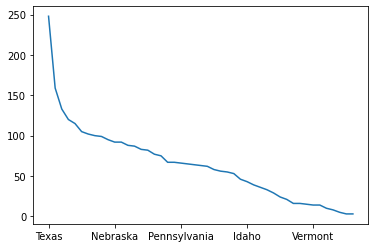

In [247]:
#analyze the categorical attribute  and count how many rows (i.e. districts) belong to each category
covid["State"].value_counts().plot()

In [248]:
election.head()
election.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3003 entries, 0 to 3002
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FIPS       3003 non-null   int64  
 1   Income     3003 non-null   int64  
 2   Older      3003 non-null   float64
 3   Urban      3003 non-null   float64
 4   Trump2016  3003 non-null   float64
 5   Trump2020  3003 non-null   float64
 6   RepGov     3003 non-null   int64  
 7   Female     3003 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 187.8 KB


In [249]:
covid.set_index("FIPS", inplace=True)
election.set_index("FIPS", inplace=True)

In [250]:
data = pd.merge(left=covid, right=election, left_index=True, right_index=True)

In [251]:
data.describe()

,Deaths,Cases,Pop,NeighborDeaths,NeighborCases,NeighborPop,Income,Older,Urban,Trump2016,Trump2020,RepGov,Female
count,3003.000000,3003.000000,3.003000e+03,3003.000000,3003.000000,3.003000e+03,3003.000000,3003.000000,3003.000000,3003.000000,3003.000000,3003.000000,3003.000000
mean,75.134865,2974.383616,1.060531e+05,428.084915,17361.105561,6.196260e+05,52423.998668,17.095431,41.525198,63.781924,65.130226,0.595738,0.169497
std,514.442122,11808.655843,3.395018e+05,1447.167096,35264.227767,1.134814e+06,13857.439179,4.308218,31.436406,15.556276,16.048659,0.490830,0.375253
min,0.000000,0.000000,4.630000e+02,0.000000,90.000000,7.110000e+03,25385.000000,4.691211,0.000000,8.342566,8.730038,0.000000,0.000000
25%,3.000000,252.000000,1.107550e+04,50.000000,3487.500000,1.278960e+05,43437.500000,14.433710,13.070000,55.081160,55.874575,0.000000,0.000000
50%,12.000000,664.000000,2.601000e+04,136.000000,7338.000000,2.630140e+05,50246.000000,16.750220,40.550000,67.055400,68.563330,1.000000,0.000000
75%,37.000000,1823.500000,6.811000e+04,310.500000,16771.000000,6.164115e+05,58236.500000,19.270130,66.825000,75.201510,77.524895,1.000000,0.000000
max,24017.000000,310595.000000,1.003911e+07,30942.000000,565083.000000,1.910359e+07,140382.000000,55.481680,100.000000,95.272730,96.181820,1.000000,1.000000


In [252]:
data.isna().sum().sum()

0

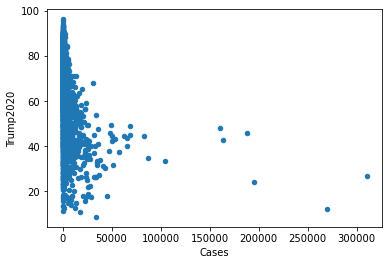

False

In [253]:
data.plot(kind='scatter', x="Cases", y='Trump2020')
plt.show()
data['Cases'].isnull().values.any()

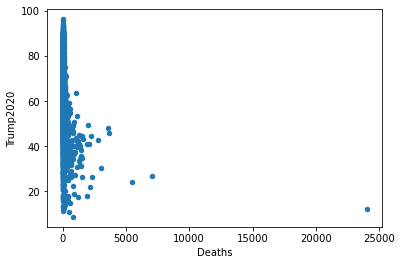

In [254]:
data.plot(kind='scatter', x="Deaths", y='Trump2020')
plt.show()

In [255]:
data['CasesperCapita']=data['Cases']/data['Pop']
data['DeathsperCapita']=data['Deaths']/data['Pop']
data['NeighborDperCapita']=data['NeighborDeaths']/data['NeighborPop']
data['NeighborCperCapita']=data['NeighborCases']/data['NeighborPop']

In [256]:
data['CasesperCapita'].isnull().values.any()
data['DeathsperCapita'].isnull().values.any()
data['NeighborDperCapita'].isnull().values.any()
data['NeighborCperCapita'].isnull().values.any()

False

In [257]:
data.dropna(inplace=True) #get rid of any na values

In [2]:
data.hist(bins=50, figsize=(20,15))
plt.show()

NameError: name 'data' is not defined

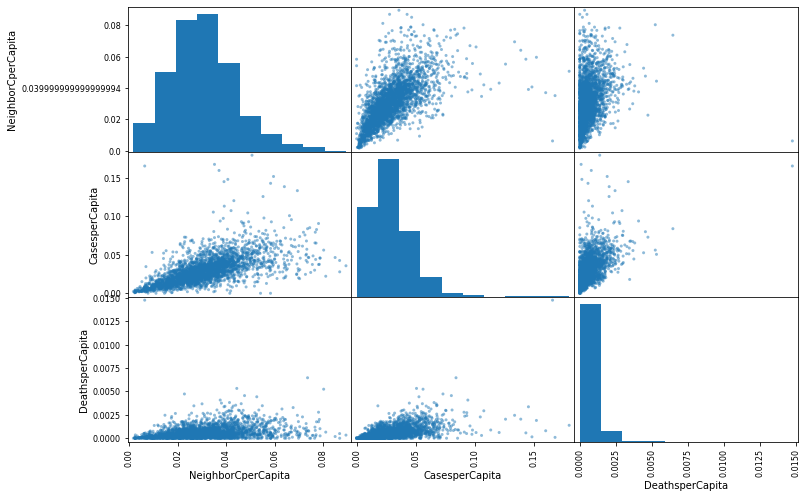

In [259]:
scatter_matrix(data[['NeighborCperCapita', 'CasesperCapita', 'DeathsperCapita']], figsize=(12,8))
plt.show()

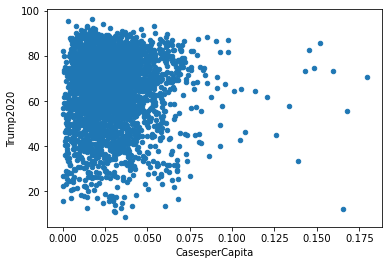

In [260]:
data.plot(kind='scatter', x="CasesperCapita", y='Trump2020')
plt.show()

In [261]:
corr_matrix = data.corr()
corr_matrix["CasesperCapita"].sort_values(ascending=False)

CasesperCapita        1.000000
NeighborCperCapita    0.627934
DeathsperCapita       0.539329
NeighborDperCapita    0.355664
RepGov                0.298602
Deaths                0.136856
Cases                 0.116902
Female                0.071197
Urban                 0.025321
Trump2020             0.012693
Trump2016            -0.011706
NeighborCases        -0.018406
Pop                  -0.020108
NeighborDeaths       -0.041093
NeighborPop          -0.089880
Older                -0.196876
Income               -0.206260
Name: CasesperCapita, dtype: float64

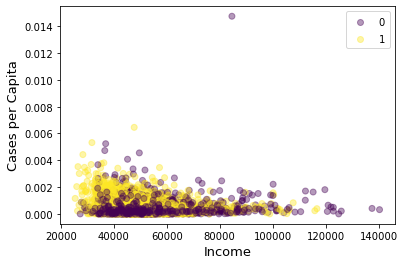

In [262]:
fig, ax = plt.subplots()
marker_colors = data['RepGov']
scatter = ax.scatter(x = data['Income'], y = data['DeathsperCapita'], c=marker_colors, alpha=.4)
plt.legend(*scatter.legend_elements())
plt.ylabel('Cases per Capita', fontsize=13)
plt.xlabel('Income', fontsize=13)
plt.show()

# Create Training and Test Sets

In [263]:
#create a strtified split object that will create 1 fold (1 set) of data
splitobj = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42)

In [264]:
for train_index, test_index in splitobj.split(data, data['State']): #strat by state
    strat_train_set = data.iloc[train_index]
    strat_test_set = data.iloc[test_index]

In [265]:
print("Data set size: {:,}\nTraining set size: {:,} \nTest set size (20%): {:,}".format(
    len(data),len(strat_train_set),len(strat_test_set)))

Data set size: 3,003
Training set size: 2,402 
Test set size (20%): 601


In [266]:
pd.DataFrame( { "Overall": data["State"].value_counts() / len(data), 
               "Stratified": strat_test_set["State"].value_counts() / len(strat_test_set) })

,Overall,Stratified
Alabama,0.022311,0.021631
Arizona,0.004995,0.004992
Arkansas,0.024975,0.024958
California,0.019314,0.019967
Colorado,0.020979,0.021631
Connecticut,0.002664,0.003328
Delaware,0.000999,0.001664
Florida,0.022311,0.021631
Georgia,0.052947,0.053245
Idaho,0.014319,0.014975


Analyze Data Further

In [267]:
#create a copy of the startified training data set to explore
data_copy= strat_train_set.copy()

In [268]:
data_copy.head()

,Date,State,County,State_Code,Deaths,Cases,Pop,NeighborDeaths,NeighborCases,NeighborPop,...,Older,Urban,Trump2016,Trump2020,RepGov,Female,CasesperCapita,DeathsperCapita,NeighborDperCapita,NeighborCperCapita
FIPS,,,,,,,,,,,,,,,,,,,,,
31105,2-Nov-20,Nebraska,Kimball,NE,0,69,3632,179,10349,456056,...,24.147340,0.00,80.50122,83.27118,1,0,0.018998,0.000000,0.000392,0.022692
5139,2-Nov-20,Arkansas,Union,AR,52,1198,38682,156,4819,145100,...,15.956650,45.50,62.43726,63.09388,1,0,0.030970,0.001344,0.001075,0.033212
13059,2-Nov-20,Georgia,Clarke,GA,50,6923,128331,148,7988,241636,...,9.800551,94.14,28.69903,28.14241,1,0,0.053946,0.000390,0.000612,0.033058
39005,2-Nov-20,Ohio,Ashland,OH,9,518,53484,282,11290,890991,...,16.733570,38.06,71.31760,73.49744,1,0,0.009685,0.000168,0.000317,0.012671
13295,2-Nov-20,Georgia,Walker,GA,46,1978,69761,371,32264,808891,...,15.899580,56.15,79.10940,78.94324,1,0,0.028354,0.000659,0.000459,0.039887


In [269]:
#from the graph above, can see the correlation of housing price and location (latitude/longitude)
#let's look at it statistically by analyzing the correlation of median_house_value to all other attributes
corr_matrix = data_copy.corr()
corr_matrix["CasesperCapita"].sort_values(ascending=False)

CasesperCapita        1.000000
NeighborCperCapita    0.632646
DeathsperCapita       0.550360
NeighborDperCapita    0.365105
RepGov                0.299677
Deaths                0.156402
Cases                 0.130910
Female                0.076523
Urban                 0.019719
Trump2020             0.010253
Pop                  -0.010269
NeighborCases        -0.013523
Trump2016            -0.017269
NeighborDeaths       -0.033575
NeighborPop          -0.087475
Income               -0.201711
Older                -0.202732
Name: CasesperCapita, dtype: float64

In [270]:
#from the graph above, can see the correlation of housing price and location (latitude/longitude)
#let's look at it statistically by analyzing the correlation of median_house_value to all other attributes
corr_matrix = data_copy.corr()
corr_matrix["Trump2020"].sort_values(ascending=False)

Trump2020             1.000000
Trump2016             0.983846
Older                 0.306692
RepGov                0.260171
NeighborCperCapita    0.177571
CasesperCapita        0.010253
Female               -0.023440
NeighborDperCapita   -0.154140
DeathsperCapita      -0.157966
Deaths               -0.208359
NeighborDeaths       -0.261967
Income               -0.276477
NeighborCases        -0.280037
Cases                -0.286228
Pop                  -0.351082
NeighborPop          -0.354070
Urban                -0.503251
Name: Trump2020, dtype: float64

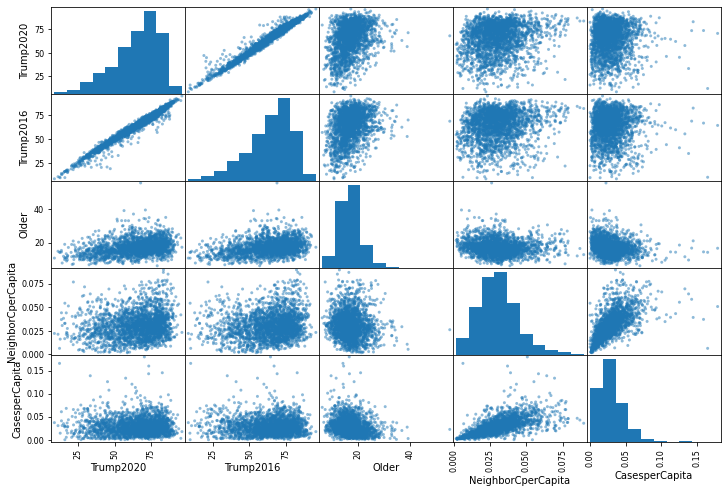

In [271]:
scatter_matrix(data_copy[['Trump2020', 'Trump2016', 'Older','NeighborCperCapita', 'CasesperCapita']], figsize=(12,8))
plt.show()

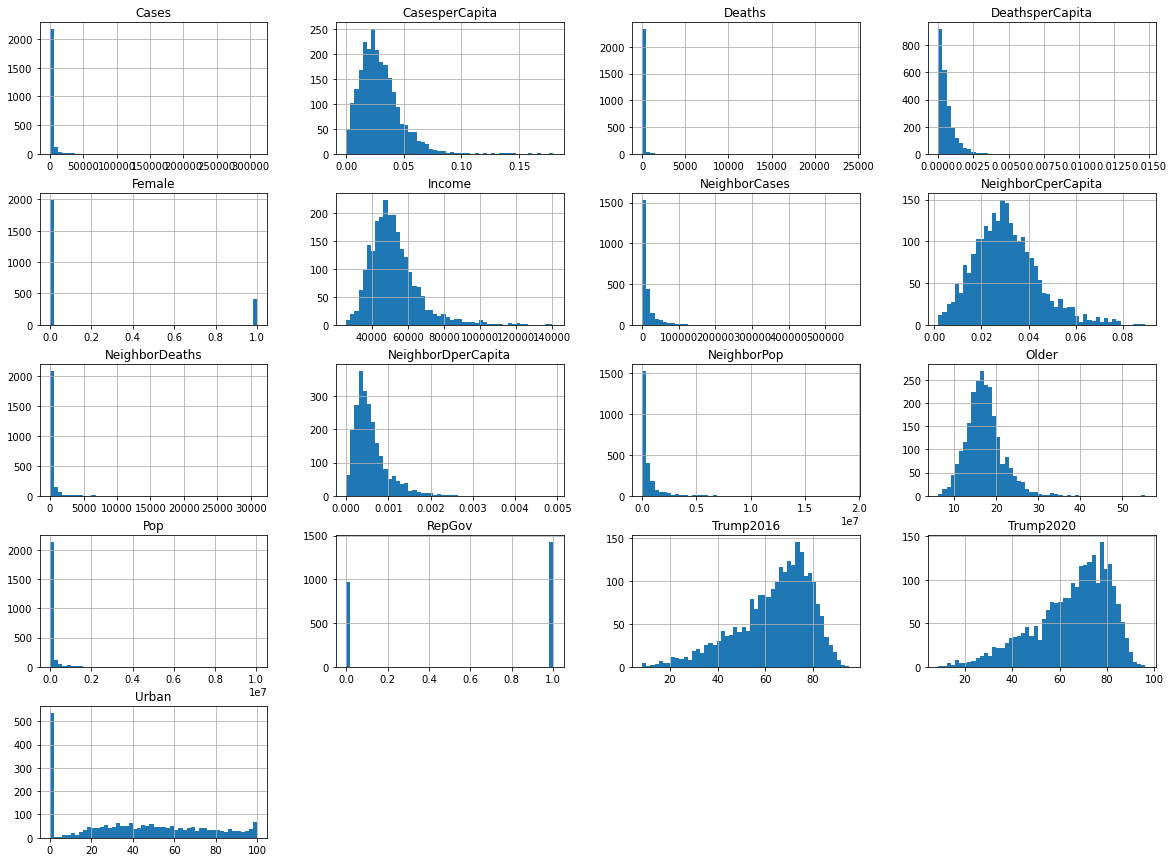

In [272]:
data_copy.hist(bins=50, figsize=(20,15))
plt.show()

In [273]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2402 entries, 31105 to 26007
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                2402 non-null   object 
 1   State               2402 non-null   object 
 2   County              2402 non-null   object 
 3   State_Code          2402 non-null   object 
 4   Deaths              2402 non-null   int64  
 5   Cases               2402 non-null   int64  
 6   Pop                 2402 non-null   int64  
 7   NeighborDeaths      2402 non-null   int64  
 8   NeighborCases       2402 non-null   int64  
 9   NeighborPop         2402 non-null   int64  
 10  Income              2402 non-null   int64  
 11  Older               2402 non-null   float64
 12  Urban               2402 non-null   float64
 13  Trump2016           2402 non-null   float64
 14  Trump2020           2402 non-null   float64
 15  RepGov              2402 non-null   int64  
 16  F

In [274]:
data_copy.drop("Date",axis=1, inplace=True)
data_copy.drop("County",axis=1,inplace=True)
data_copy.drop("State_Code",axis=1,inplace=True)

# Cleanse data

In [275]:
# assign x and y within the training set
data = data_copy.drop("Trump2020",axis=1) #X value
data_labels = data_copy["Trump2020"].copy() #Y value

#create an array of prepared data based on the test data set
X_test_pre = strat_test_set.drop(['Trump2020'],axis=1)
X_test_pre.drop("Date",axis=1, inplace=True)
X_test_pre.drop("County",axis=1,inplace=True)
X_test_pre.drop("State_Code",axis=1,inplace=True)
y_test = strat_test_set['Trump2020'].copy()

In [276]:
data.info() #no missing values, no need to use imputer?

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2402 entries, 31105 to 26007
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   State               2402 non-null   object 
 1   Deaths              2402 non-null   int64  
 2   Cases               2402 non-null   int64  
 3   Pop                 2402 non-null   int64  
 4   NeighborDeaths      2402 non-null   int64  
 5   NeighborCases       2402 non-null   int64  
 6   NeighborPop         2402 non-null   int64  
 7   Income              2402 non-null   int64  
 8   Older               2402 non-null   float64
 9   Urban               2402 non-null   float64
 10  Trump2016           2402 non-null   float64
 11  RepGov              2402 non-null   int64  
 12  Female              2402 non-null   int64  
 13  CasesperCapita      2402 non-null   float64
 14  DeathsperCapita     2402 non-null   float64
 15  NeighborDperCapita  2402 non-null   float64
 16  N

In [277]:
#define variables needed to seperate numeric attributes from categorical attributes
cat_attribs = ["State"]
num_attribs = list(data.drop(cat_attribs,axis=1) )

#list the numeric attributes
num_attribs

['Deaths',
 'Cases',
 'Pop',
 'NeighborDeaths',
 'NeighborCases',
 'NeighborPop',
 'Income',
 'Older',
 'Urban',
 'Trump2016',
 'RepGov',
 'Female',
 'CasesperCapita',
 'DeathsperCapita',
 'NeighborDperCapita',
 'NeighborCperCapita']

In [278]:
#define pipeline for numeric attributes (this code is just a definition)
#each numeric attribute will be imputated using the Median strategy
#each numeric attribute will be scaled 
# each of numeric columns, run each through imputer and fill any empty values w median
#standard scalar standardizes through each numeric column
num_pipeline = Pipeline( [
 ('imputer', SimpleImputer(strategy="median")),
 ('std_scaler', StandardScaler()),   
])

#define transformation pipeline for both numeric and category attributes in the dataframe
#numeric attributed will be processed by the num_pipeline defined above
#the category ocean proximity will be transformed using the One Hot Encoder method

full_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

In [279]:
#take the training data set and create an array of prepared data
#transform data into matrix, figuring out scalers and encoders should be
data_prepared = full_pipeline.fit_transform(data)
data_prepared.shape

(2402, 63)

In [280]:
#preserve column names for One Hot Encoded columns (will need this later for testing and feature selection)
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
cat_one_hot_attribs

['Alabama',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'Florida',
 'Georgia',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin']

In [281]:
# only transform, do not fit test data
X_test = full_pipeline.transform(X_test_pre)
X_test.shape

(601, 63)

# Establish a Baseline

In [282]:
data_prepared.shape

(2402, 63)

In [283]:
data_labels

FIPS
31105    83.27118
5139     63.09388
13059    28.14241
39005    73.49744
13295    78.94324
           ...   
29075    79.73432
18013    64.32468
53005    58.58803
48267    86.69285
26007    62.97366
Name: Trump2020, Length: 2402, dtype: float64

In [284]:
#calculate the average vote value; assuming peole vote the same way 
baseline_prediction = data["Trump2016"] #2016 value

#populate an array with the average home value
predictions = data_labels #2020 value
baseline_rmse = mean_squared_error(baseline_prediction, predictions, squared=False)
baseline_mae = mean_absolute_error(baseline_prediction, predictions)
print("Baseline Performance (of this guess):  MAE {:,.2f}%".format(baseline_mae))
print("Baseline Performance (of this guess): RMSE {:,.2f}%".format(baseline_rmse))

Baseline Performance (of this guess):  MAE 2.18%
Baseline Performance (of this guess): RMSE 3.17%


# Linear Regression

In [285]:
lin_reg = LinearRegression()
lin_reg.fit(data_prepared,data_labels)

LinearRegression()

In [286]:
#create a linear regression model
lin_reg=LinearRegression()

#fit the model to the training data set
lin_reg.fit(data_prepared, data_labels)

#calculated the predicted values for the training data set
predictions = lin_reg.predict(data_prepared)

#compare the predicted to the actuals
rmse = mean_squared_error(data_labels,predictions, squared=False)
mae  = mean_absolute_error(data_labels, predictions)

print("Predition Error (RMSE): {:,.2f}%".format(rmse))
print("Predition Error  (MAE): {:,.2f}%".format(mae))

Predition Error (RMSE): 2.10%
Predition Error  (MAE): 1.41%


In [287]:
#run cross validation
scores = cross_val_score(lin_reg, data_prepared, data_labels, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: {:,.2f}%".format( -scores.mean() ) )

RMSE: 2.22%


In [288]:
#use the linear regression model and evaluate the test data set
predictions = lin_reg.predict(X_test)

#compare the predicted to the actuals
rmse = mean_squared_error(y_test,predictions, squared=False)
mae  = mean_absolute_error(y_test, predictions)

print("Predition Error (RMSE): {:,.2f}%".format(rmse))
print("Predition Error  (MAE): {:,.2f}%".format(mae))

Predition Error (RMSE): 2.04%
Predition Error  (MAE): 1.44%


The exact solution is  x = 0                              


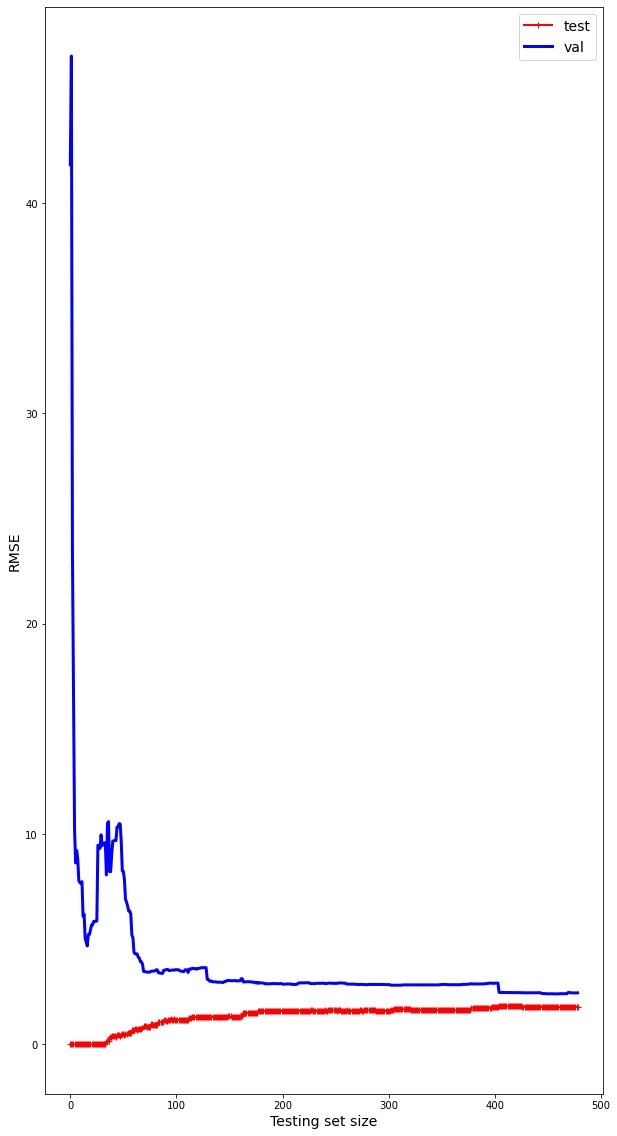

In [328]:
plot_learning_curves(lin_reg,X_test, y_test)

In [290]:
# for linear regression models, the coeffient of each attribute signifies its importance
attributes = list(num_attribs) + list(cat_one_hot_attribs)
sorted(zip(lin_reg.coef_, attributes), reverse=True)

[(15.420447871834439, 'Trump2016'),
 (11.04668696291851, 'Utah'),
 (4.0397942612005275, 'New Mexico'),
 (4.019607415653589, 'Idaho'),
 (2.37139925212259, 'Nevada'),
 (1.9417479532993356, 'Ohio'),
 (1.8927397884621622, 'North Dakota'),
 (1.8263914653746738, 'Deaths'),
 (1.8008136468300877, 'Minnesota'),
 (1.6029695690827201, 'Arkansas'),
 (1.3679501088892985, 'California'),
 (1.2007044239573985, 'NeighborDeaths'),
 (1.145623449965315, 'Illinois'),
 (1.0048404093162253, 'Indiana'),
 (0.7869159799962763, 'Iowa'),
 (0.7643195016000076, 'Texas'),
 (0.7338672206727609, 'Oklahoma'),
 (0.5910318366148992, 'Cases'),
 (0.5540194199792927, 'West Virginia'),
 (0.3158749886076134, 'Washington'),
 (0.286925131462125, 'RepGov'),
 (0.2602670382165444, 'Female'),
 (0.2583466440586853, 'Oregon'),
 (0.25691904523697884, 'NeighborPop'),
 (0.16204567963862226, 'Montana'),
 (0.1496002023767546, 'NeighborCperCapita'),
 (0.14087633264666866, 'CasesperCapita'),
 (0.13512582362441472, 'Missouri'),
 (0.046751544

# Ridge Regression

In [291]:
#create a Ridge Regression model
ridge_reg=Ridge(alpha=1,solver="auto")

#fit the model to the training data set
ridge_reg.fit(data_prepared, data_labels)

#calculated the predicted values for the training data set
predictions = ridge_reg.predict(data_prepared)

#compare the predicted to the actuals
rmse = mean_squared_error(data_labels,predictions, squared=False)
mae  = mean_absolute_error(data_labels, predictions)

print("Predition Error (RMSE): {:,.2f}%".format(rmse))
print("Predition Error  (MAE): {:,.2f}%".format(mae))

Predition Error (RMSE): 2.11%
Predition Error  (MAE): 1.42%


In [292]:
#run cross validation
scores = cross_val_score(ridge_reg, data_prepared, data_labels, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: {:,.02f}%".format( -scores.mean() ) )

RMSE: 2.21%


In [293]:
#create a parameter grid that determines the variable hyperparameters
param_grid = [
    # try all solvers available to Ridge Regression and a few values for alpha
    {'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'saga'],
     'alpha': [.01, .5, 1]}
]

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(ridge_reg, param_grid, cv=10,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True)

#fit the data to the model
grid_search.fit(data_prepared, data_labels)

C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 548, in fit
    raise ValueError(
ValueError: solver='svd' does not support fitting the intercept on sparse data. Please set the solver to 'auto' or 'sparse_cg', 'sag', or set `fit_intercept=False`

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\model_selec

C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 548, in fit
    raise ValueError(
ValueError: solver='saga' does not support fitting the intercept on sparse data. Please set the solver to 'auto' or 'sparse_cg', 'sag', or set `fit_intercept=False`

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\model_sele

C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 548, in fit
    raise ValueError(
ValueError: solver='cholesky' does not support fitting the intercept on sparse data. Please set the solver to 'auto' or 'sparse_cg', 'sag', or set `fit_intercept=False`

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\model_

C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 548, in fit
    raise ValueError(
ValueError: solver='saga' does not support fitting the intercept on sparse data. Please set the solver to 'auto' or 'sparse_cg', 'sag', or set `fit_intercept=False`

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\model_sele

C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 548, in fit
    raise ValueError(
ValueError: solver='svd' does not support fitting the intercept on sparse data. Please set the solver to 'auto' or 'sparse_cg', 'sag', or set `fit_intercept=False`

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\model_selec

C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 548, in fit
    raise ValueError(
ValueError: solver='saga' does not support fitting the intercept on sparse data. Please set the solver to 'auto' or 'sparse_cg', 'sag', or set `fit_intercept=False`

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\model_sele

GridSearchCV(cv=10, estimator=Ridge(alpha=1),
             param_grid=[{'alpha': [0.01, 0.5, 1],
                          'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                     'sparse_cg', 'saga']}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [294]:
#display the best soluiton
grid_search.best_params_

{'alpha': 1, 'solver': 'auto'}

In [295]:
#print the RMSE results from the CV and the paramaters used during each run 
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("RMSE: {:,.2f}% - {}".format( -mean_score, params) )

RMSE: 2.21% - {'alpha': 0.01, 'solver': 'auto'}
RMSE: nan% - {'alpha': 0.01, 'solver': 'svd'}
RMSE: nan% - {'alpha': 0.01, 'solver': 'cholesky'}
RMSE: nan% - {'alpha': 0.01, 'solver': 'lsqr'}
RMSE: 2.21% - {'alpha': 0.01, 'solver': 'sparse_cg'}
RMSE: nan% - {'alpha': 0.01, 'solver': 'saga'}
RMSE: 2.21% - {'alpha': 0.5, 'solver': 'auto'}
RMSE: nan% - {'alpha': 0.5, 'solver': 'svd'}
RMSE: nan% - {'alpha': 0.5, 'solver': 'cholesky'}
RMSE: nan% - {'alpha': 0.5, 'solver': 'lsqr'}
RMSE: 2.21% - {'alpha': 0.5, 'solver': 'sparse_cg'}
RMSE: nan% - {'alpha': 0.5, 'solver': 'saga'}
RMSE: 2.21% - {'alpha': 1, 'solver': 'auto'}
RMSE: nan% - {'alpha': 1, 'solver': 'svd'}
RMSE: nan% - {'alpha': 1, 'solver': 'cholesky'}
RMSE: nan% - {'alpha': 1, 'solver': 'lsqr'}
RMSE: 2.21% - {'alpha': 1, 'solver': 'sparse_cg'}
RMSE: nan% - {'alpha': 1, 'solver': 'saga'}


In [296]:
grid_search.best_params_

{'alpha': 1, 'solver': 'auto'}

In [297]:
#use the parameters found above to create the model
model = Ridge(**grid_search.best_params_)

#fit the model to the training data set
model.fit(data_prepared, data_labels)

Ridge(alpha=1)

In [298]:
#use the best ridge regression model and evaluate the test data set
predictions = model.predict(X_test)

#compare the predicted to the actuals
rmse = mean_squared_error(y_test,predictions, squared=False)
mae  = mean_absolute_error(y_test, predictions)

print("Predition Error (RMSE): {:,.2f}%".format(rmse))
print("Predition Error  (MAE): {:,.2f}%".format(mae))

Predition Error (RMSE): 2.04%
Predition Error  (MAE): 1.43%


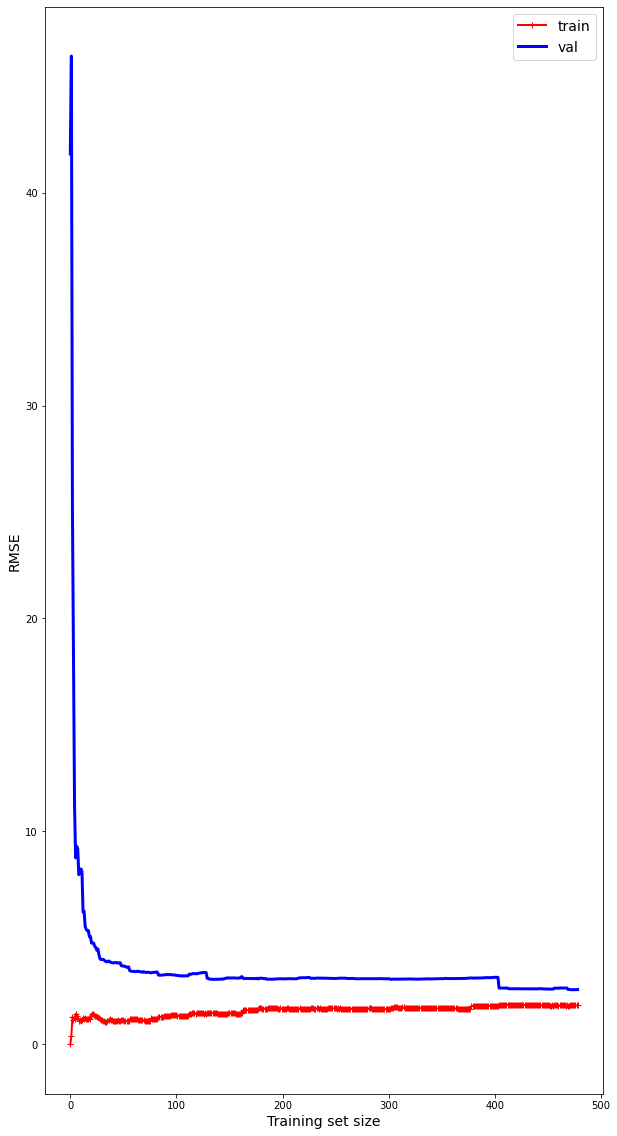

In [299]:
plot_learning_curves(ridge_reg,X_test,y_test)

In [300]:
sorted(zip(ridge_reg.coef_, attributes), reverse=True)

[(15.372578756426925, 'Trump2016'),
 (7.260568223767617, 'Utah'),
 (3.6933579441743976, 'New Mexico'),
 (3.532060717985288, 'Idaho'),
 (1.663935555884443, 'Ohio'),
 (1.3949652035928726, 'North Dakota'),
 (1.140430010420359, 'California'),
 (1.0844082686405034, 'Arkansas'),
 (1.0296763970706062, 'Minnesota'),
 (0.9133612448623617, 'Nevada'),
 (0.9086173851159461, 'Cases'),
 (0.8779680398610321, 'NeighborDeaths'),
 (0.7440827126093591, 'Iowa'),
 (0.6728139782493874, 'Texas'),
 (0.6640301691687891, 'Indiana'),
 (0.5623005898748483, 'Illinois'),
 (0.45092777505682896, 'Deaths'),
 (0.3587506895873229, 'Oklahoma'),
 (0.2618142728991645, 'Oregon'),
 (0.168008243550359, 'NeighborCperCapita'),
 (0.1648293895234445, 'CasesperCapita'),
 (0.13398747959725563, 'RepGov'),
 (0.0994576606449462, 'NeighborCases'),
 (0.08526436851174315, 'Female'),
 (0.047148132662665466, 'DeathsperCapita'),
 (0.0, 'Wisconsin'),
 (0.0, 'Rhode Island'),
 (-0.0014116607174102242, 'West Virginia'),
 (-0.11102139708696138, 

# Lasso Regression

In [301]:
#create a Lasso Regression model
lasso_reg=Lasso(alpha=.1)

#fit the model to the training data set
lasso_reg.fit(data_prepared, data_labels)

#calculated the predicted values for the training data set
predictions = lasso_reg.predict(data_prepared)

#compare the predicted to the actuals
rmse = mean_squared_error(data_labels,predictions, squared=False)
mae  = mean_absolute_error(data_labels, predictions)

print("Predition Error (RMSE): {:,.2f}%".format(rmse))
print("Predition Error  (MAE): {:,.2f}%".format(mae))

Predition Error (RMSE): 2.66%
Predition Error  (MAE): 1.78%


In [302]:
#run cross validation
scores = cross_val_score(lasso_reg, data_prepared, data_labels, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: {:,.2f}%".format( -scores.mean() ) )

RMSE: 2.67%


In [303]:
#create a parameter grid that determines the variable hyperparameters
param_grid = [
    {     'alpha': [.01, .05, .1, .5, 1]}    
  ]

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(lasso_reg, param_grid, cv=10,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True)

#fit the data to the model
grid_search.fit(data_prepared, data_labels)

GridSearchCV(cv=10, estimator=Lasso(alpha=0.1),
             param_grid=[{'alpha': [0.01, 0.05, 0.1, 0.5, 1]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [304]:
#display the best soluiton
grid_search.best_params_

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("RMSE: {:,.2f}% - {}".format( -mean_score, params) )

RMSE: 2.21% - {'alpha': 0.01}
RMSE: 2.49% - {'alpha': 0.05}
RMSE: 2.67% - {'alpha': 0.1}
RMSE: 2.78% - {'alpha': 0.5}
RMSE: 3.01% - {'alpha': 1}


In [305]:
#use the parameters found above to create the model
model = Lasso(**grid_search.best_params_)

#fit the model to the training data set
model.fit(data_prepared, data_labels)

Lasso(alpha=0.01)

In [306]:
#use the best Lasso Regression model and evaluate the test data set
predictions = model.predict(X_test)

#compare the predicted to the actuals
rmse = mean_squared_error(y_test,predictions, squared=False)
mae  = mean_absolute_error(y_test, predictions)

print("Predition Error (RMSE): {:,.2f}%".format(rmse))
print("Predition Error  (MAE): {:,.2f}%".format(mae))

Predition Error (RMSE): 2.07%
Predition Error  (MAE): 1.44%


C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11577900050682657, tolerance: 0.05209384848724667
  model = cd_fast.sparse_enet_coordinate_descent(


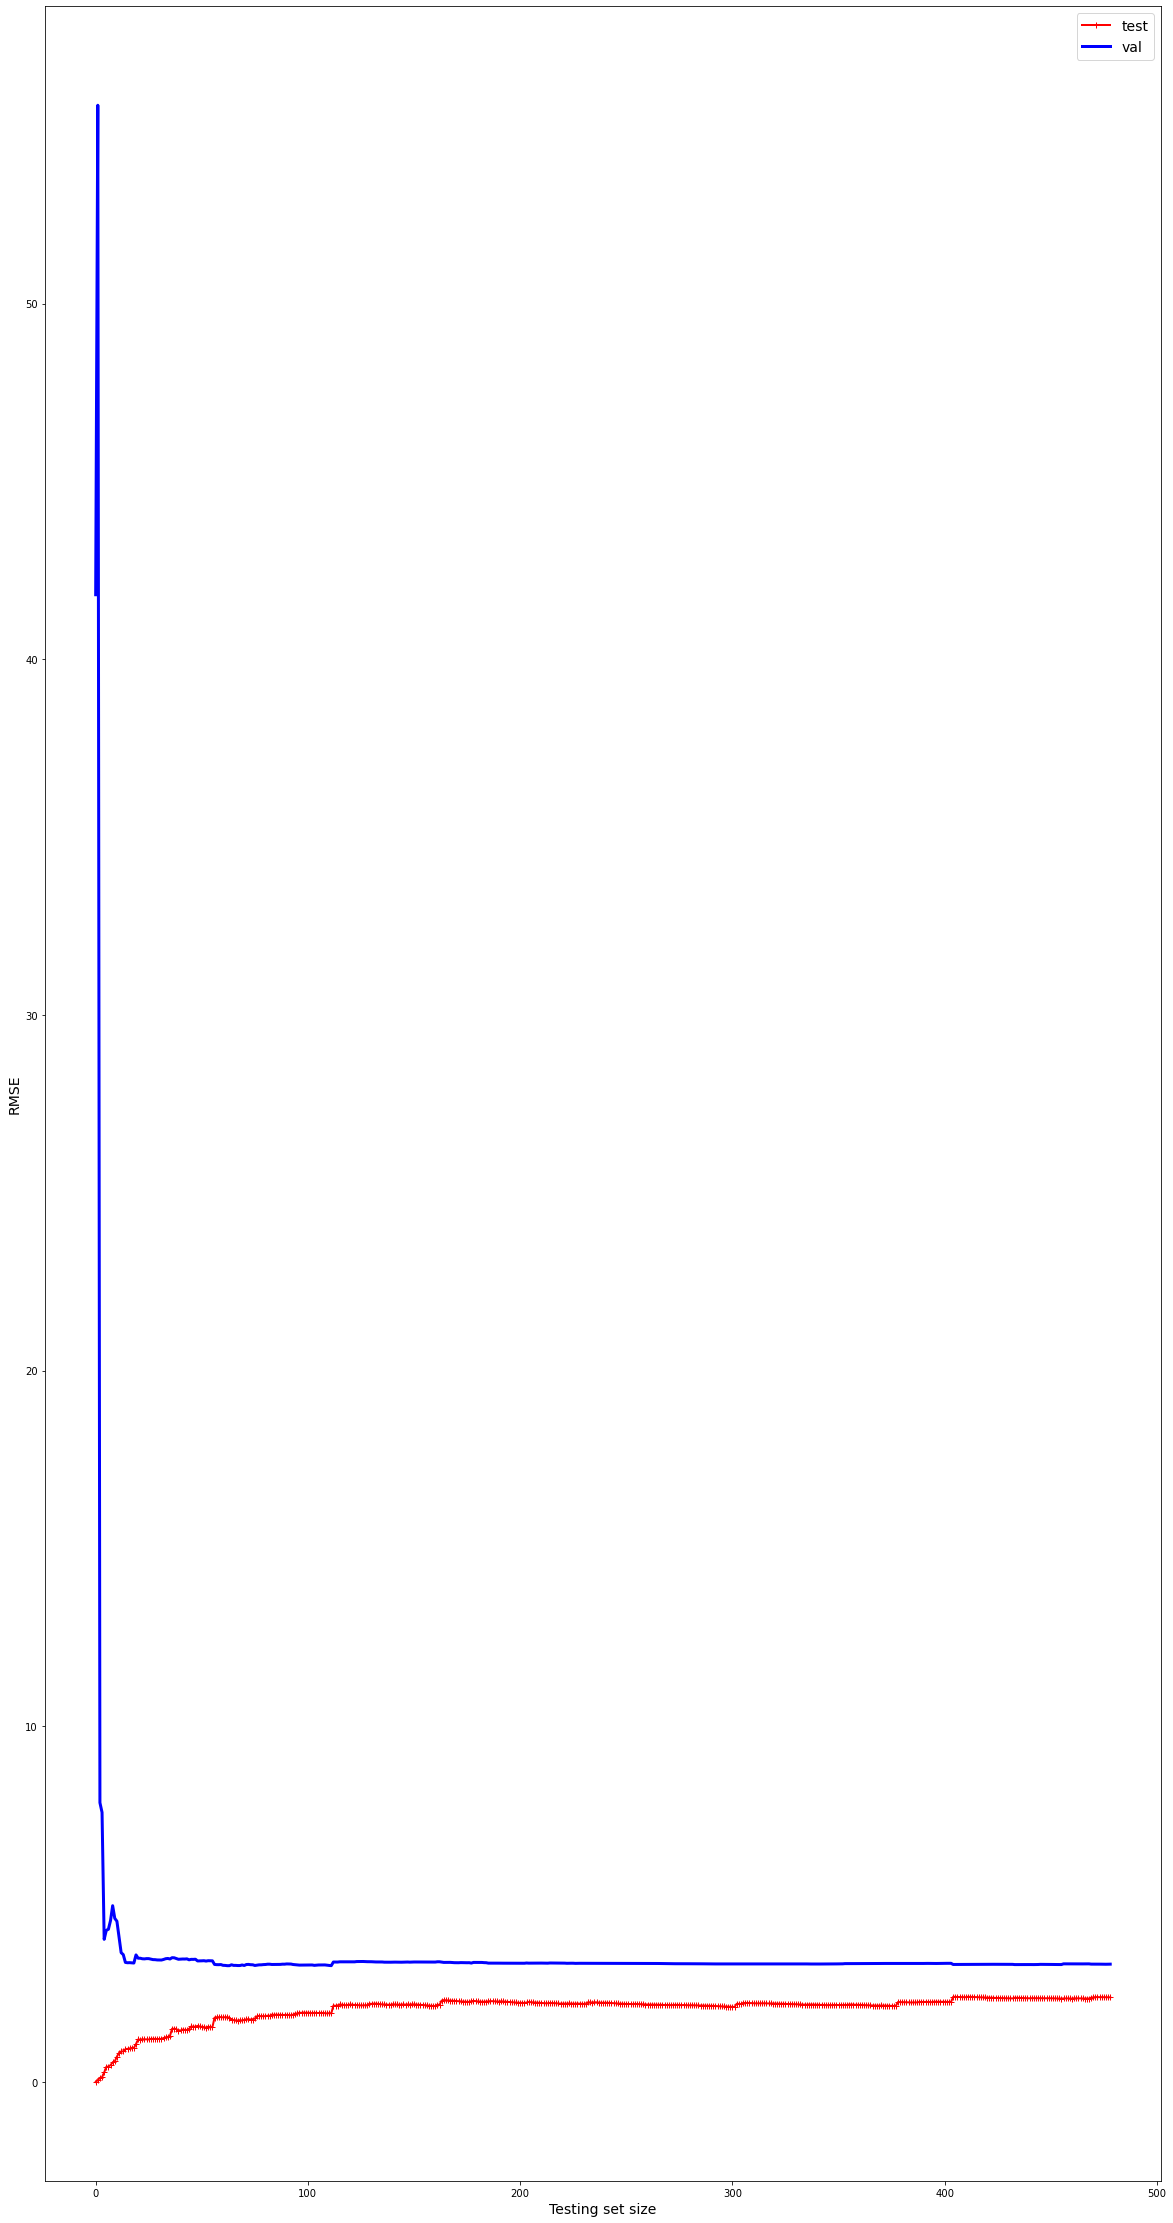

In [325]:
plot_learning_curves(lasso_reg,X_test,y_test)

In [308]:
sorted(zip(lasso_reg.coef_, attributes), reverse=True)

[(15.520022302160088, 'Trump2016'),
 (0.1761316729544634, 'NeighborCperCapita'),
 (0.1205839771178742, 'RepGov'),
 (0.10279397151310155, 'NeighborDeaths'),
 (0.0, 'Wisconsin'),
 (0.0, 'West Virginia'),
 (-0.0, 'Washington'),
 (-0.0, 'Virginia'),
 (-0.0, 'Vermont'),
 (0.0, 'Utah'),
 (0.0, 'Texas'),
 (-0.0, 'Tennessee'),
 (-0.0, 'South Dakota'),
 (0.0, 'South Carolina'),
 (0.0, 'Rhode Island'),
 (-0.0, 'Pop'),
 (-0.0, 'Pennsylvania'),
 (-0.0, 'Oregon'),
 (0.0, 'Older'),
 (0.0, 'Oklahoma'),
 (0.0, 'Ohio'),
 (0.0, 'North Dakota'),
 (-0.0, 'North Carolina'),
 (-0.0, 'New York'),
 (0.0, 'New Mexico'),
 (-0.0, 'New Jersey'),
 (-0.0, 'New Hampshire'),
 (0.0, 'Nevada'),
 (-0.0, 'NeighborPop'),
 (0.0, 'NeighborCases'),
 (-0.0, 'Nebraska'),
 (-0.0, 'Montana'),
 (-0.0, 'Missouri'),
 (-0.0, 'Mississippi'),
 (0.0, 'Minnesota'),
 (-0.0, 'Michigan'),
 (-0.0, 'Massachusetts'),
 (-0.0, 'Maryland'),
 (-0.0, 'Maine'),
 (-0.0, 'Louisiana'),
 (-0.0, 'Kentucky'),
 (0.0, 'Kansas'),
 (0.0, 'Iowa'),
 (0.0, 'Ind

# Elastic Net Regression

In [309]:
#create a Elastic Net Regression model
elnet_reg=ElasticNet(alpha=.1, l1_ratio=.5)

#fit the model to the training data set
elnet_reg.fit(data_prepared, data_labels)

#calculated the predicted values for the training data set
predictions = elnet_reg.predict(data_prepared)

#compare the predicted to the actuals
rmse = mean_squared_error(data_labels,predictions, squared=False)
mae  = mean_absolute_error(data_labels, predictions)

print("Predition Error (RMSE): {:,.2f}%".format(rmse))
print("Predition Error  (MAE): {:,.2f}%".format(mae))

Predition Error (RMSE): 2.72%
Predition Error  (MAE): 1.89%


In [310]:
#run cross validation
scores = cross_val_score(elnet_reg, data_prepared, data_labels, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: {:,.2f}%".format( -scores.mean() ) )

RMSE: 2.74%


C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.sparse_enet_coordinate_descent(


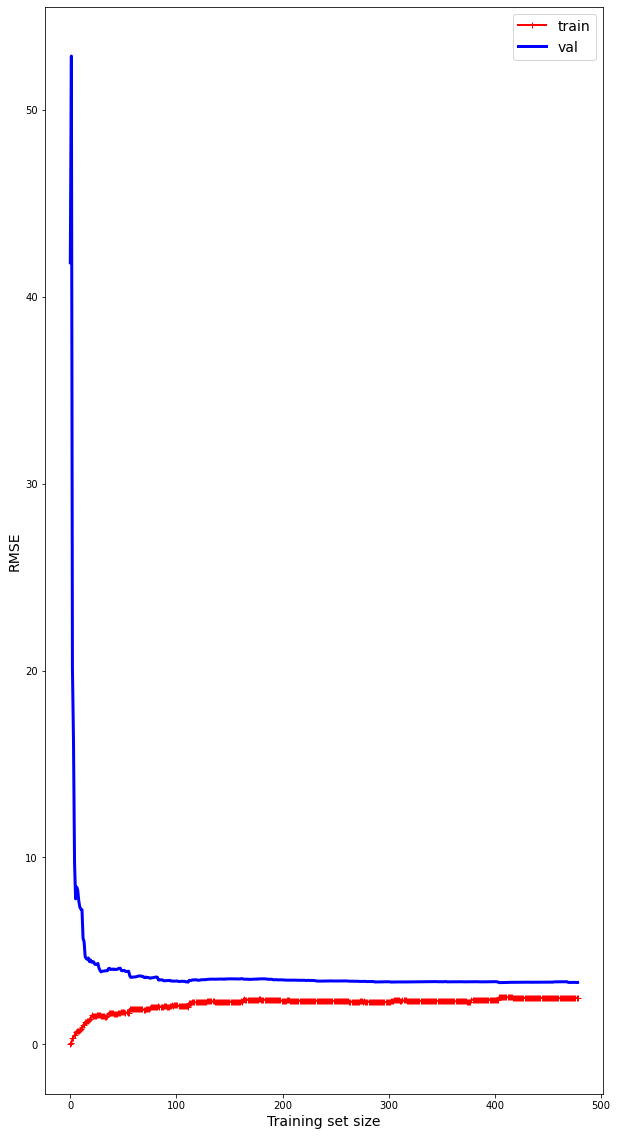

In [311]:
plot_learning_curves(elnet_reg,X_test,y_test)

In [312]:
#create a parameter grid that determines the variable hyperparameters
param_grid = [
    {     'alpha': [.01, .05, .1, .5, 1]}    
  ]

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(elnet_reg, param_grid, cv=10,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True)

#fit the data to the model
grid_search.fit(data_prepared, data_labels)

GridSearchCV(cv=10, estimator=ElasticNet(alpha=0.1),
             param_grid=[{'alpha': [0.01, 0.05, 0.1, 0.5, 1]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [313]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("RMSE: {:,.2f}% - {}".format( -mean_score, params) )

RMSE: 2.25% - {'alpha': 0.01}
RMSE: 2.54% - {'alpha': 0.05}
RMSE: 2.74% - {'alpha': 0.1}
RMSE: 4.27% - {'alpha': 0.5}
RMSE: 5.94% - {'alpha': 1}


In [314]:
grid_search.best_params_

{'alpha': 0.01}

In [315]:
#use the parameters found above to create the model
model = ElasticNet(**grid_search.best_params_)

#fit the model to the training data set, check that data labels is y_train?
model.fit(data_prepared, data_labels)

ElasticNet(alpha=0.01)

In [316]:
#use the best Lasso Regression model and evaluate the test data set
predictions = model.predict(X_test)

#compare the predicted to the actuals
rmse = mean_squared_error(y_test,predictions, squared=False)
mae  = mean_absolute_error(y_test, predictions)

print("Predition Error (RMSE): {:,.2f}%".format(rmse))
print("Predition Error  (MAE): {:,.2f}%".format(mae))

Predition Error (RMSE): 2.15%
Predition Error  (MAE): 1.46%


In [317]:
sorted(zip(elnet_reg.coef_, attributes), reverse=True)

[(14.336242348014471, 'Trump2016'),
 (0.43407637261560283, 'NeighborCperCapita'),
 (0.29099813790382767, 'RepGov'),
 (0.2804737565342951, 'NeighborDeaths'),
 (0.2441170807921723, 'Utah'),
 (0.21442457742175974, 'Texas'),
 (0.11151243195394263, 'Idaho'),
 (0.10013509734353988, 'Older'),
 (0.0, 'Wisconsin'),
 (0.0, 'West Virginia'),
 (-0.0, 'Washington'),
 (-0.0, 'Virginia'),
 (-0.0, 'Vermont'),
 (0.0, 'Tennessee'),
 (-0.0, 'South Dakota'),
 (-0.0, 'South Carolina'),
 (0.0, 'Rhode Island'),
 (-0.0, 'Pennsylvania'),
 (-0.0, 'Oregon'),
 (0.0, 'Oklahoma'),
 (0.0, 'Ohio'),
 (0.0, 'North Dakota'),
 (-0.0, 'North Carolina'),
 (-0.0, 'New York'),
 (0.0, 'New Mexico'),
 (0.0, 'New Jersey'),
 (-0.0, 'New Hampshire'),
 (0.0, 'Nevada'),
 (0.0, 'NeighborCases'),
 (-0.0, 'Nebraska'),
 (-0.0, 'Montana'),
 (0.0, 'Missouri'),
 (0.0, 'Minnesota'),
 (-0.0, 'Michigan'),
 (-0.0, 'Massachusetts'),
 (-0.0, 'Maryland'),
 (-0.0, 'Maine'),
 (0.0, 'Louisiana'),
 (-0.0, 'Kentucky'),
 (0.0, 'Kansas'),
 (0.0, 'Iowa'

# Delaware County Predictions

In [318]:
# use dictionary for predictions, note: changed state code to state bc dropped code earlier 
Delco={'State' : ['Pennsylvania'],
     'Deaths': [815],
     'Cases': [14081],
     'Pop': [566747],
     'NeighborDeaths': [3772],
     'NeighborCases': [87424],
     'NeighborPop': [3790357],
     'Income': [71961],
     'Older': [14.76567],
     'Urban': [99.54],
     'Trump2016': [37.41118],
     'RepGov': [0],
     'Female': [0],'FIPS':[45]}
predict_Del=pd.DataFrame.from_dict(Delco)
predict_Del['CasesperCapita']=predict_Del['Cases']/predict_Del['Pop']
predict_Del['DeathsperCapita']=predict_Del['Deaths']/predict_Del['Pop']
predict_Del['NeighborCperCapita']=predict_Del['NeighborCases']/predict_Del['NeighborPop']
predict_Del['NeighborDperCapita']=predict_Del['NeighborDeaths']/predict_Del['NeighborPop']
predict_Del.set_index('FIPS', inplace=True)

In [319]:
predict_Del_prepared=full_pipeline.transform(predict_Del)
lin_predictions=lin_reg.predict(predict_Del_prepared)
ridge_predictions=ridge_reg.predict(predict_Del_prepared)
lasso_predictions=lasso_reg.predict(predict_Del_prepared)
elnet_predictions=elnet_reg.predict(predict_Del_prepared)

C:\Users\ocmkd\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


In [320]:
"The predicted percentage of votes for Trump in Delaware County, according to the Linear Regression Model, for 2020 is: {:.2f}%".format(float(lin_predictions))

'The predicted percentage of votes for Trump in Delaware County, according to the Linear Regression Model, for 2020 is: 38.47%'

In [321]:
"The predicted percentage of votes for Trump in Delaware County, according to the Ridge Regression Model, for 2020 is: {:.2f}%".format(float(ridge_predictions))

'The predicted percentage of votes for Trump in Delaware County, according to the Ridge Regression Model, for 2020 is: 36.69%'

In [322]:
"The predicted percentage of votes for Trump in Delaware County, according to the Lasso Regression Model, for 2020 is: {:.2f}%".format(float(lasso_predictions))

'The predicted percentage of votes for Trump in Delaware County, according to the Lasso Regression Model, for 2020 is: 36.84%'

In [323]:
"The predicted percentage of votes for Trump in Delaware County, according to the Elastic Net Regression Model, for 2020 is: {:.2f}%".format(float(elnet_predictions))

'The predicted percentage of votes for Trump in Delaware County, according to the Elastic Net Regression Model, for 2020 is: 37.21%'